In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math

In [2]:
fDF = pd.read_csv('Data/featureTypes.txt', names=['featureID'])

In [28]:
trainDF = pd.read_csv('Data/trainData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
YDF = pd.read_csv('Data/trainLabels.txt', names = ['label'])
valXDF = pd.read_csv('Data/valData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
valYDF = pd.read_csv('Data/valLabels.txt', names = ['label'])
#print trainDF.shape[0]

In [29]:
W = np.random.rand(d)
B = 0
TempBArray = np.ones(n)

In [13]:
# Will lead to negative index if re-running
trainDF['instanceID'] -= 1
trainDF['featureID'] -= 1
sMat = csr_matrix((trainDF['value'], (trainDF['featureID'], trainDF['instanceID'])))
valXDF['instanceID'] -= 1
valXDF['featureID'] -= 1
valX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
Y = YDF['label'].as_matrix().transpose()
valY = valYDF['label'].as_matrix().transpose()

In [16]:
X = sMat.copy()

(3000, 10000)


In [18]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    return 2 * (abs(X * YNorm).max())
    
print initLamda(X, Y)

1271.869651


In [20]:
redFact = 2

In [21]:
# change this to convergence condition
def rmse(input1, input2):
    out = input1 - input2
    #print out
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W
        self.B = B
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.001
        # Stores Lamda and respective RMSE
        self.trainrmse = []
        self.trainlamda = []
        self.valrmse = []
        self.vallamda = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        # Lamda = initLamda(self.X, self.Y)
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
            # 4.1.1
            XTW = (self.X.transpose() * self.W)
            R = self.Y - (self.X.transpose() * self.W) - self.B
            
            # 4.1.2
            BOld = self.B
            self.B = np.full(n, (R + self.B).sum() / n) 
            #print B.shape
            # 4.1.3
            R =  R + BOld - self.B
            #print 'RSHAPE', R.shape
            #print 'R', R
            #R = self.Y - (XTW + self.B)
            #print R.shape
            #print R[:5]
            # R = R.reshape(-1)
            for ik in range(0, d):
                # 4.1.4
                #ik = 0
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                #print t
                #print t.shape
                #print R.shape
                Ck = 2*( self.X[ik] * (R + t)).sum()
                #print 'CK:', Ck
                # Update Weight
                WkOld = self.W[ik]
                #print 'OW: ', WkOld
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                #print 'W: ', WkOld, self.W[ik]
                #print W[ik]
                # 4.1.5
                # print self.W[ik], WkOld
                #print X[ik].toarray().reshape(-1).shape, R.shape
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
                #R = self.Y - (self.X.transpose() * self.W) + self.B
            oldLoss = newLoss
            newLoss = model.loss()
            #print oldLoss, newLoss, oldLoss - newLoss
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + np.full(X.transpose().shape[0], self.B))
    
    def chooseCorrectLamda(self, delta = -1):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        self.fit()
        
        newRMSE = rmse(self.predict(self.X), self.Y)
        #self.TrainInfo.append([self.Lamda, newRMSE])
        self.trainrmse.append(newRMSE)
        self.trainlamda.append(self.Lamda)
        valRMSE = rmse(self.predict(valX), valY)
        self.valrmse.append(valRMSE)
        self.vallamda.append(self.Lamda)
        oldRMSE = valRMSE
        #print W
        #self.ValInfo.append([self.Lamda, valRMSE])
        self.NonZero.append((self.W != 0.0).sum())
        print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
        
        while self.Lamda >= 3: #oldRMSE >= valRMSE:
            oldLamda = self.Lamda
            self.Lamda /= redFact
            self.fit()
            oldRMSE = valRMSE
            #self.TrainInfo.append([self.Lamda, newRMSE])
            newRMSE = rmse(self.predict(self.X), self.Y)
            self.trainrmse.append(newRMSE)
            self.trainlamda.append(self.Lamda)
            valRMSE = rmse(self.predict(valX), valY)
            #self.ValInfo.append([self.Lamda, valRMSE])
            self.valrmse.append(valRMSE)
            self.vallamda.append(self.Lamda)
            self.NonZero.append(np.count_nonzero(self.W))
            #self.NonZero.append(self.W.toarray().count_nonzero())
            print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
            self.saveModel('optimal_saved_Model')
            
    
def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [22]:
model = Lasso(X, Y, W, B, initLamda(X.copy(), Y.copy()))
#model.loss()
#model.fit()

In [23]:
print model.Lamda

1271.869651


In [24]:
#model.Lamda = 2.48
model.chooseCorrectLamda()

Lamda:  1271.869651
LOSS: 154246.592887
LOSS: 125033.318514
LOSS: 115835.703677
LOSS: 115339.9759
LOSS: 115339.9759
Lamda:  1271.869651 RMSE:  3.39617396345 Val RMSE: 3.38958619451
Lamda:  635.9348255
LOSS: 113464.97052
LOSS: 113351.724815
LOSS: 113268.054226
LOSS: 113230.355473
LOSS: 113218.396063
LOSS: 113214.759373
LOSS: 113213.598487
LOSS: 113213.216459
LOSS: 113213.088791
LOSS: 113213.045865
LOSS: 113213.031406
LOSS: 113213.026535
LOSS: 113213.024894
LOSS: 113213.024341
Lamda:  635.9348255 RMSE:  3.23821018036 Val RMSE: 3.2410399759
Lamda:  317.96741275
LOSS: 104745.115491
LOSS: 104554.504161
LOSS: 104545.427939
LOSS: 104541.901036
LOSS: 104540.436746
LOSS: 104539.825153
LOSS: 104539.567215
LOSS: 104539.456931
LOSS: 104539.409025
LOSS: 104539.387932
LOSS: 104539.378562
LOSS: 104539.374383
LOSS: 104539.372516
LOSS: 104539.371683
Lamda:  317.96741275 RMSE:  2.98746454354 Val RMSE: 3.00146619137
Lamda:  158.983706375
LOSS: 93412.0068453
LOSS: 93142.7292818
LOSS: 93116.3773824
LOSS: 9

LOSS: 40030.4602226
LOSS: 39859.7289835
LOSS: 39830.8510949
LOSS: 39819.0256716
LOSS: 39810.7980556
LOSS: 39803.4655535
LOSS: 39796.5409137
LOSS: 39789.8655336
LOSS: 39783.3468865
LOSS: 39777.0203491
LOSS: 39770.8478643
LOSS: 39764.8111972
LOSS: 39758.9215023
LOSS: 39753.155918
LOSS: 39747.5494042
LOSS: 39742.1205256
LOSS: 39736.875656
LOSS: 39731.8298263
LOSS: 39727.0063029
LOSS: 39722.4090349
LOSS: 39718.0388661
LOSS: 39713.90468
LOSS: 39710.0090292
LOSS: 39706.3506565
LOSS: 39702.9258397
LOSS: 39699.7292504
LOSS: 39696.7527565
LOSS: 39693.9846179
LOSS: 39691.4113644
LOSS: 39689.0182475
LOSS: 39686.7923857
LOSS: 39684.7246801
LOSS: 39682.8035039
LOSS: 39681.0165863
LOSS: 39679.3530035
LOSS: 39677.8028456
LOSS: 39676.3562773
LOSS: 39675.0050114
LOSS: 39673.7412914
LOSS: 39672.5580489
LOSS: 39671.4490059
LOSS: 39670.4083974
LOSS: 39669.4318685
LOSS: 39668.5149251
LOSS: 39667.6536625
LOSS: 39666.8448987
LOSS: 39666.0866539
LOSS: 39665.3780124
LOSS: 39664.7166047
LOSS: 39664.0995713
LOSS

In [43]:
#model.Lamda = 2.2
#model.chooseCorrectLamda()

Lamda:  2.18
LOSS: 32111.4725364
Lamda:  2.18 RMSE:  1.56227305382 Val RMSE: 1.9501772567
Lamda:  2.16
LOSS: 32040.6626365
LOSS: 32040.6401938
LOSS: 32040.6342396
LOSS: 32040.6318288
LOSS: 32040.6305979
LOSS: 32040.6298379
Lamda:  2.16 RMSE:  1.56118567653 Val RMSE: 1.95051595998


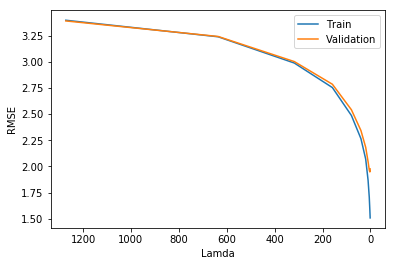

In [20]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

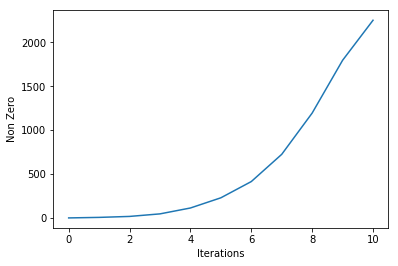

[0, 6, 17, 46, 113, 229, 414, 724, 1194, 1795, 2251]
2251


In [24]:
import matplotlib.pyplot as plt
plt.plot(model.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
#plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print model.NonZero
print np.count_nonzero(model.W)
#plt.savefig('NonZeroElements.png')

In [21]:
model.saveModel('savedModeltill3')

In [22]:
#print model.lamda
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY

1.94746234814
82.9623798309
[ 91.4244674   92.86989377  87.52762187 ...,  91.66197947  88.13588147
  91.14908862]
[92 90 86 ..., 92 89 88]


In [28]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
testPredicted = model.predict(testX)
print testPredicted
np.savetxt("out3.csv", testPredicted, delimiter=",")
#testPredicted.to_csv('out.csv')

[ 105.71206656   85.54415933   87.60385796 ...,   87.82942353   87.01643808
   85.78716094]


In [ ]:
# Mixture
bigData = (X + valX) / 2


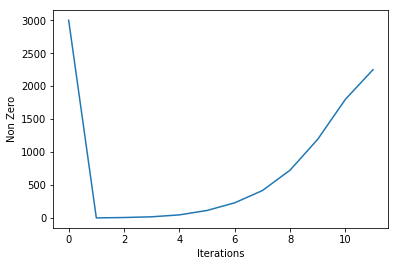

In [56]:
#loadedModel = loadModel('./finalData/savedModel')
#plt.plot(loadedModel.NonZero)
#plt.ylabel('Non Zero')
#plt.xlabel('Iterations')
#plt.show()

In [71]:
#print loadedModel.W
#WLoaded = list(loadedModel.W)
#sorted(range(len(WLoaded)), key=lambda i: WLoaded[i])[-10:]
#print WLoaded[2468]
#print max(WLoaded)

[ 0.          3.70430265  5.27646819 ..., -0.17621468  0.91925534
  1.82692104]
8.76831112942
11.2180665852


In [1]:
#print loadedModel.trainlamda[1:]
#print loadedModel.trainrmse.shape
#plt.plot(loadedModel.trainlamda[1:], loadedModel.trainrmse)
#plt.plot(loadedModel.vallamda[1:], loadedModel.valrmse)
#lt.ylabel('RMSE')
#plt.xlabel('Lamda')
#ax = plt.gca()
##ax.invert_xaxis()
##plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

In [23]:
#valModel = Lasso(valX, valY, W, B, model.Lamda)


In [2]:
#valModel.Lamda = 2.4466

#valModel.fit()

In [3]:
#print model.lamda
#print rmse(model.predict(valX), valY)
#print rmse(X.transpose() * model.W, valY)
#print model.predict(valX)
#print valY
#print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
#print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


In [4]:
#print model.lamda
#print rmse(model.predict(valX), valY)
#print rmse(X.transpose() * model.W, valY)
##print model.predict(valX)
#print valY
#print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
#print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


In [31]:
#testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
##testXDF['instanceID'] -= 1
#testXDF['featureID'] -= 1
#testX = csr_matrix((testXDF['value'], (testXDF['featureID'], testXDF['instanceID'])))
#print testX.shape[0]
#testPredicted = (testX.transpose() * valModel.W) + np.full(testX.transpose().shape[0], valModel.B[0])
#np.full(X.transpose().shape[0], self.B)
#testPredicted = valModel.predict(testX)
#print testPredicted
#np.savetxt("out3.csv", testPredicted, delimiter=",", )

3000
[ 90.64266457  82.70100871  88.68079993 ...,  88.03124281  87.9261721
  87.17292611]


In [78]:
#from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(valX.transpose(), valY)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
#print clf.predict(valX.transpose()).shape
#print rmse(valY, clf.predict(valX.transpose()))

(10000,)
3.38956530546


In [48]:
#t1 = pd.read_csv('./out1.csv', sep=',')
#t2 = pd.read_csv('./out2.csv', sep=',')
#print t1

In [49]:
#rmse(t1['Points'], t2['Points'])

0.6094172680553226